In [15]:
# Import libraries
import torch
import numpy as np
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import pandas as pd
import umap
import matplotlib.animation as animation
from PIL import Image
import matplotlib.colors as mcolors
import cv2

# Import other complementary scripts
from models.pl_inference import ReidPrediction
from datasets.dataloader import ReidDataModule

In [16]:
#Parameteres
class Config():
    cat_testing_dir = 'data/sample/images/'
    cat_anno_test_file = 'data/sample/sample_anno.csv'
    evaluation_file = 'data/sample/gt_sample.json'
    number_workers = 8
    num_classes = 300
    batch_size_test = 1
    size_full_image = (256,512)
    embeddings = 2560
    arcface = False
    backbone = 'resnet152'
    deterministic = [True, "warn"]
    precision = "16-mixed"
    trained_model = 'best_model.pth'

# Creating dataloader
cat_data = ReidDataModule(data_directory=Config(),
                            batch_size_test = Config().batch_size_test,
                            num_workers= Config().number_workers, 
                            size_full_image = Config().size_full_image)
# Call the setup method
cat_data.setup()

# Create the model
eval_model = ReidPrediction(
    backbone_model = Config().backbone,
    number_classes = Config().num_classes, 
    embedding_size = Config().embeddings,
    arcface = False)

# Create the trainer
trainer = Trainer(accelerator='gpu', logger = False, 
                enable_checkpointing=False, 
                precision = Config().precision, 
                deterministic = Config().deterministic)

# Load the weights and biases
eval_model.full_image_model.load_state_dict(torch.load('pretrained_weights/' + Config().trained_model))

# Evaluation of model
predictions = trainer.predict(eval_model,cat_data.test_dataloader())


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 55.91it/s]


In [17]:
# Check how many entities we have
anno_sample = pd.read_csv(Config.cat_anno_test_file)

# Entities
sample_entities = np.unique(anno_sample['entityid'])
# List of some colours
color_list = ['red','blue','green','black','lightblue','yellow','pink','brown','darkblue']

# Define a color mapping dictionary
colors_entity = {}
for idx, entity in enumerate(sample_entities):
    colors_entity[entity] = color_list[idx]

# Create a list with the proper colors
color_samples = [colors_entity[id] for id in anno_sample['entityid']]

# Get the embeddings
sample_embeddings = eval_model.pred_embeddings.cpu().numpy()

# Create a  new representation using UMAP
embedding = umap.UMAP(n_components=2,
                      min_dist=0.8,
                      metric='cosine')
umap_embeddings = embedding.fit_transform(sample_embeddings)

# Have the name of images
img_ids = eval_model.pred_img_id

IMAGES_PATH = 'data/sample/images/'

In [18]:
# Function to transform color name to RGB
def color_name_to_rgb(color_name):
    try:
        # Get the RGB values for the given color name
        rgb_tuple = mcolors.CSS4_COLORS[color_name]
        rgb = mcolors.hex2color(rgb_tuple)
        rgb = tuple(int(val * 255) for val in rgb)
        return rgb
    except KeyError:
        print(f"Color '{color_name}' not found.")
        return None
    
# Function to add a border to an image
def add_border(image, border_color, border_width):
    bordered_image = cv2.copyMakeBorder(image, border_width, border_width, border_width, border_width, cv2.BORDER_CONSTANT, value=border_color)
    return bordered_image

# Specify the border color
border_width = 10

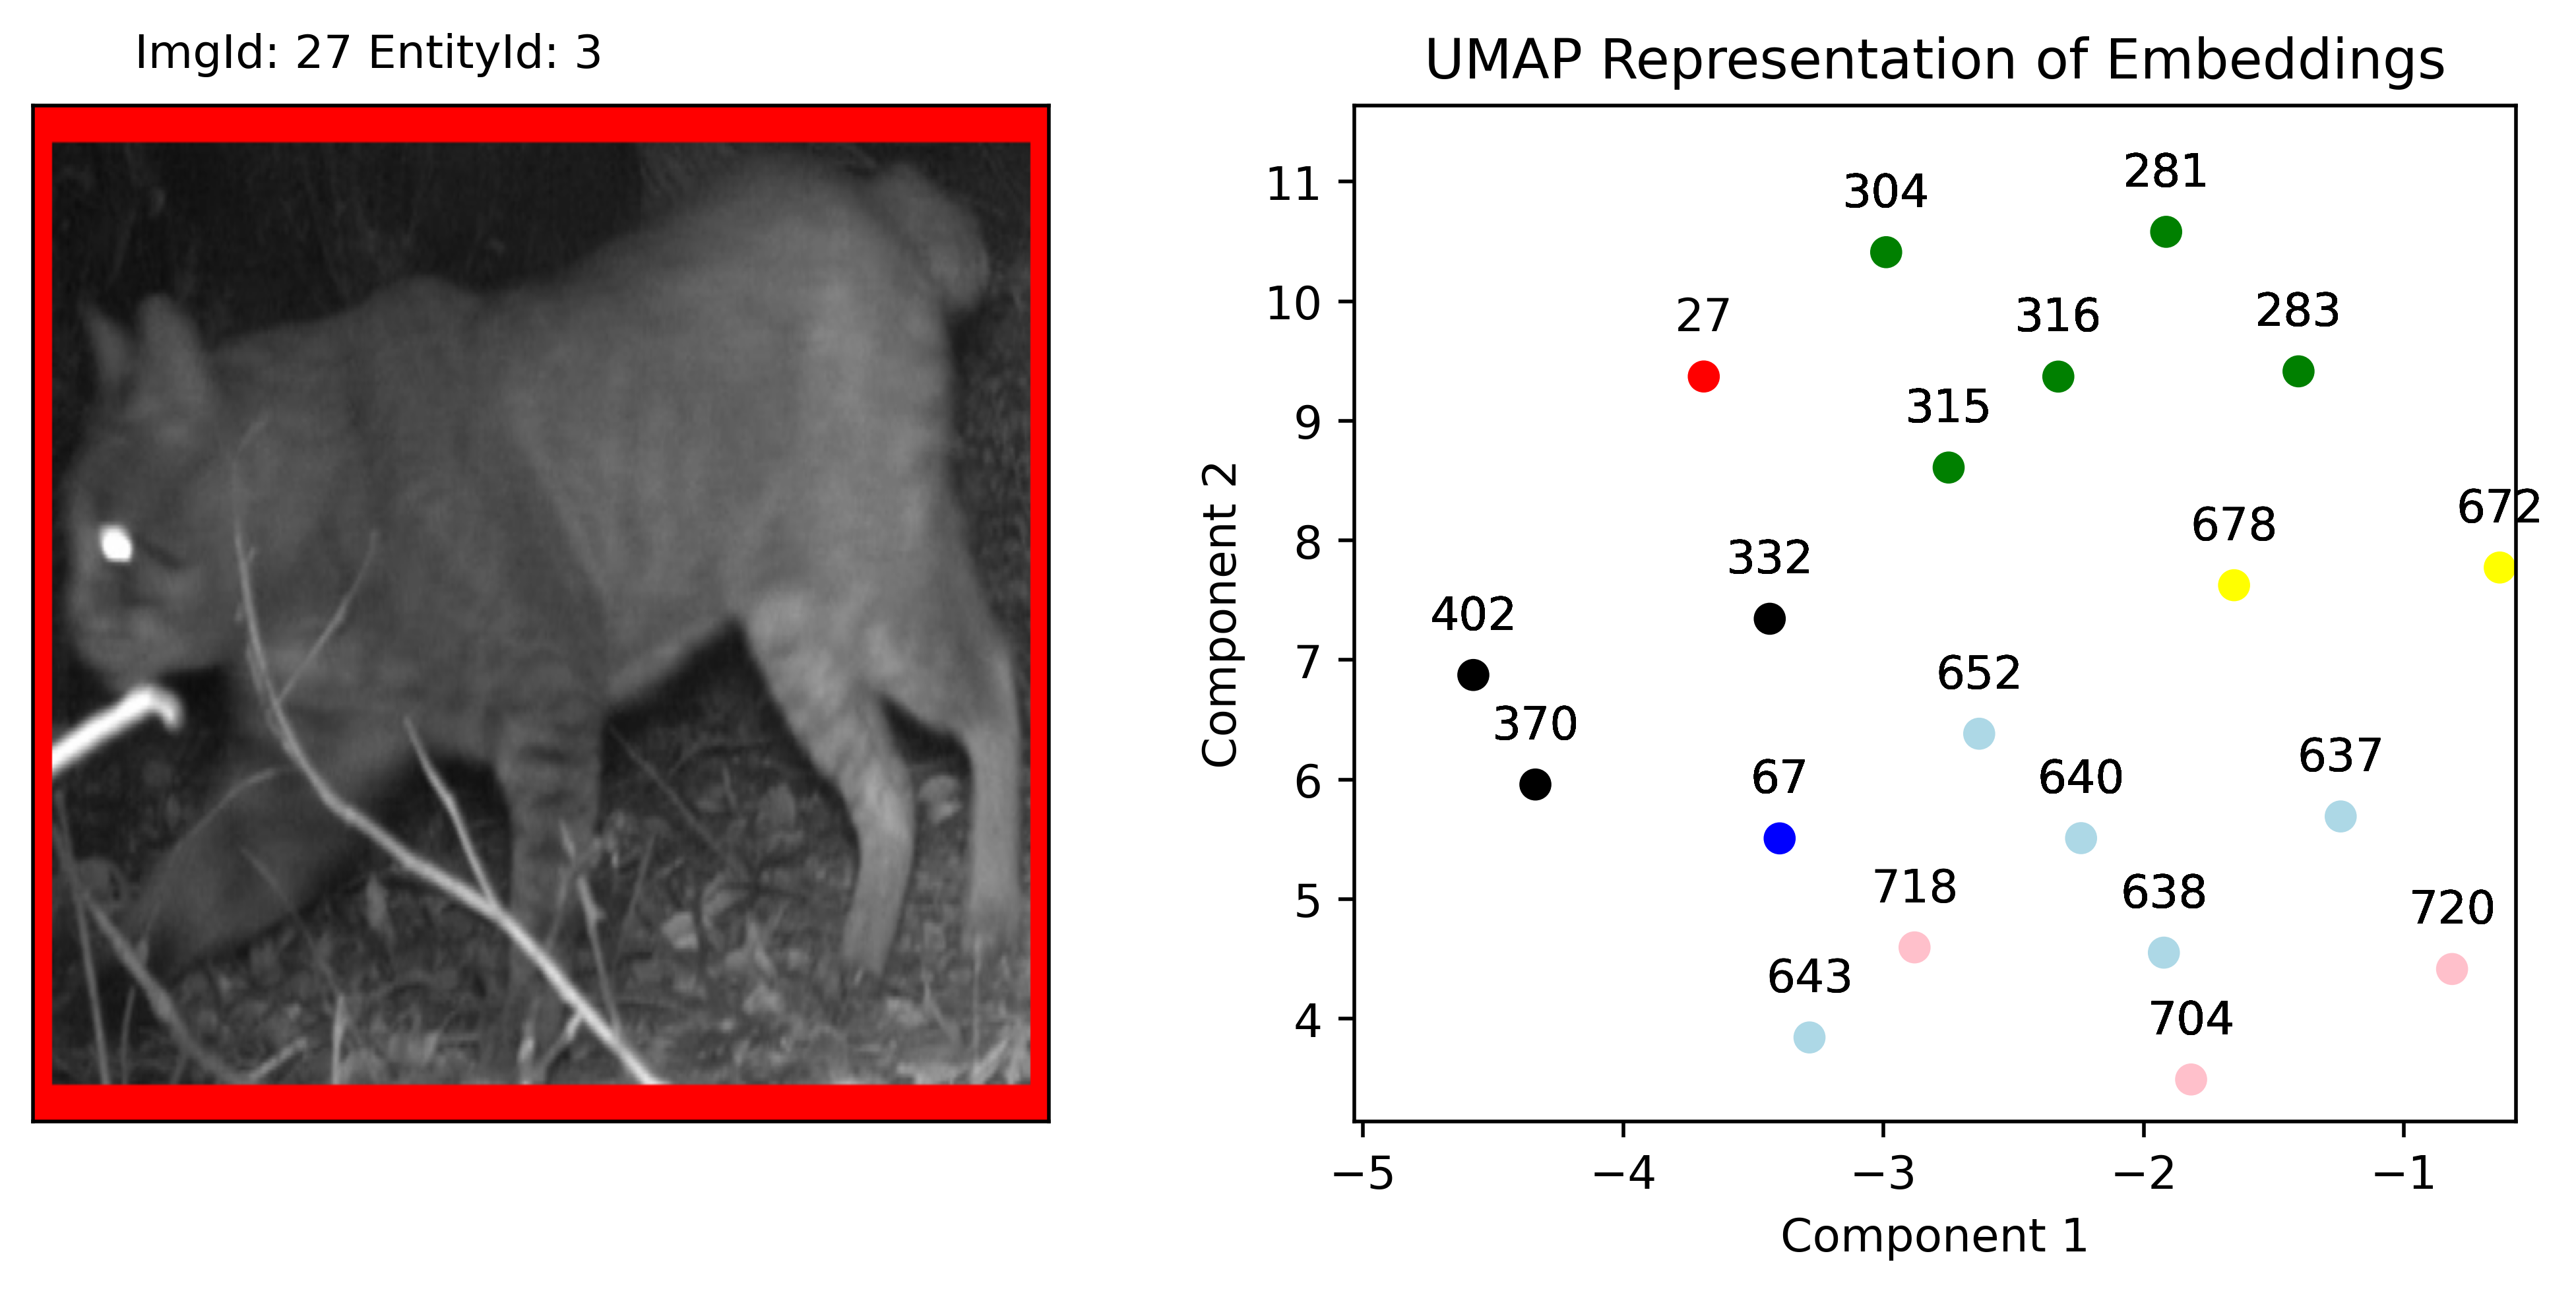

In [20]:
# Create main plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4),dpi = 500)

# Initialize an empty image object in the first subplot
img_obj = axes[0].imshow(np.zeros((1, 1, 3), dtype=np.uint8))
axes[0].set(xticks = [], yticks = [])

# Initialize a scatterplot in the second subplot
scatter_plot = axes[1].scatter(umap_embeddings[0,0], umap_embeddings[0,1], c=color_samples[0])
axes[1].set(xlabel = 'Component 1', ylabel = 'Component 2',title = 'UMAP Representation of Embeddings')

# Define title
title_text = axes[0].text(0.1, 1.05, "", transform=axes[0].transAxes, va='center')

# Function to update the image and scatterplot in each animation frame
def update(frame):

    # Define data for cat images
    img = Image.open(IMAGES_PATH + str(img_ids[frame]) + '.jpg')
    img = img.resize((512,256))
    # Add a border to each image
    color_rgb = color_name_to_rgb(color_samples[frame])

    img = add_border(np.array(img), color_rgb, border_width)
    img_obj.set_data(img) 

    # Set the title to the name of the current image
    title_text.set_text('ImgId: ' + str(img_ids[frame]) + ' EntityId: ' + str(anno_sample['entityid'][frame]))

    # Define the data for the scatterplot
    x1 = umap_embeddings[:frame+1,0]
    y1 = umap_embeddings[:frame+1,1]
    c1 = color_samples[:frame+1]
    data = np.stack([x1, y1]).T
    scatter_plot.set_offsets(data)

    # Set colors of points based on the 'labels' variable
    scatter_plot.set_color(c1)

    # Define the new limits
    x_min, x_max = x1.min(), x1.max()
    y_min, y_max = y1.min(), y1.max()
    axes[1].set_xlim(x_min - 0.1*abs(x_min), x_max + 0.1*abs(x_max))
    axes[1].set_ylim(y_min - 0.1*abs(y_min), y_max + 0.1*abs(y_max))

    # Add labels to the scatterplot
    for i, label in enumerate(img_ids[:frame+1]):
        axes[1].annotate(label, (umap_embeddings[i,0], umap_embeddings[i,1]), textcoords="offset points", xytext=(0, 10), ha='center')

    # Return the plots
    return (img_obj, scatter_plot)

# Create an animation that updates the image and scatterplot
anim = animation.FuncAnimation(fig=fig, func=update, frames=len(img_ids), interval=1200)

# Create animation
anim.save(filename="images/pred_samples.gif", writer="pillow")

# Show the animation
plt.show()
